In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
#Módulos utilizados

# Cargando los datos

In [2]:
# Se cargan los datos de train y de test
train = pd.read_csv('COVID19_open_line_list.csv')
test = pd.read_csv('COVID19_open_line_list.csv')

#Se eliminan columnas que no contienen nada
train.drop(['Unnamed: '+str(x) for x in range(33,45)],axis=1,inplace=True)
test.drop(['Unnamed: '+str(x) for x in range(33,45)],axis=1,inplace=True)
train.head()

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,Baohe District,Hefei City,Anhui,China,340111,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,Feidong County,Hefei City,Anhui,China,340122,NaN


In [3]:
#Se enlistan todas las columnas del dataset para saber cuáles son útiles en una predicción
list(train.columns.values)

['ID',
 'age',
 'sex',
 'city',
 'province',
 'country',
 'wuhan(0)_not_wuhan(1)',
 'latitude',
 'longitude',
 'geo_resolution',
 'date_onset_symptoms',
 'date_admission_hospital',
 'date_confirmation',
 'symptoms',
 'lives_in_Wuhan',
 'travel_history_dates',
 'travel_history_location',
 'reported_market_exposure',
 'additional_information',
 'chronic_disease_binary',
 'chronic_disease',
 'source',
 'sequence_available',
 'outcome',
 'date_death_or_discharge',
 'notes_for_discussion',
 'location',
 'admin3',
 'admin2',
 'admin1',
 'country_new',
 'admin_id',
 'data_moderator_initials']

In [4]:
original_train = train.copy() # Clonar el dataset para no modificar el original.
full_data = [train, test] # Utilizando full_data se modificará el set de train y de test.

# Modificando el dataset
Se debe de modificar el dataset para que los datos que se tengan puedan ser usados. Las columnas que sí se usarán para el árbol de decisión son edad, sexo, síntomas, enfermedad crónica y desenlace.

### Edad

In [5]:
train['age'].unique() # Se enlistan todas las edad que se mencionan

array(['30', '47', '49', '50', nan, '42', '59', '39', '38', '45', '33',
       '37', '32', '18', '56', '44', '65', '21', '41', '70', '43', '31',
       '24', '40', '66', '36', '10', '63', '78', '76', '48', '62', '46',
       '34', '72', '20', '54', '2', '29', '61', '51', '80', '69', '28',
       '55', '68', '57', '35', '27', '52', '22', '23', '88', '19', '60',
       '58', '53', '25', '36-45', '26', '64', '30-39', '11', '50-59',
       '73', '74', '7', '82', '67', '15', '16', '60-69', '40-49', '80-89',
       '27-40', '5', '3', '4', '71', '20-29', '77', '75', '16-80', '94',
       '38-68', '23-72', '81', '0.58333', '17', 'Belgium', '8', '9',
       '0.08333', '12', '0.5', '83', '84', '60-60', '1', '79', '87',
       '22-80', '19-77', '8-68', '21-72', '40-89', '0.25', '13-19',
       '70-79', '80-80', '0-6', '0-10', '10-19', '96', '1.75', '18-65',
       '0-18'], dtype=object)

In [6]:
# Función que convierte a entero o si no se puede convierte a nan.
def regresarEntero(x):
    try:
        y = int(x)
        return y
    except:
        return np.nan

# Se reemplazan a los nulls por edades utilizand la media y el std.
for dataset in full_data:
    age_avg = dataset['age'].apply(regresarEntero).mean()
    age_std = dataset['age'].apply(regresarEntero).std()
    age_null_count = dataset['age'].apply(regresarEntero).isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['age'].apply(regresarEntero)), 'age'] = age_null_random_list
    dataset['age'] = dataset['age'].astype(int)

In [7]:
train['age'].unique() # Se muestran los nuevos valores para 'age'

array([30, 47, 49, 50, 54, 42, 31, 59, 39, 28, 38, 45, 41, 33, 32, 37, 18,
       56, 35, 51, 27, 46, 44, 65, 21, 29, 43, 53, 34, 70, 36, 57, 24, 40,
       48, 66, 10, 63, 58, 78, 76, 62, 72, 20,  2, 61, 80, 69, 55, 68, 52,
       22, 23, 88, 19, 60, 25, 26, 64, 11, 73, 74,  7, 82, 67, 15, 16,  5,
        3,  4, 71, 77, 75, 94, 81, 17,  8,  9, 12, 83, 84,  1, 79, 87, 96])

### Sexo

In [8]:
train['sex'].unique() # Se enlistan los valores de 'sex'

array(['male', 'female', nan, '4000', 'Female', 'Male'], dtype=object)

In [9]:
# Se unifican los valores de 'male' y 'female'. Se crea una categoría para los nan.
for dataset in full_data:
    dataset['sex'] = dataset['sex'].replace(['Female', '4000'], 'female')
    dataset['sex'] = dataset['sex'].replace('Male', 'male')
    dataset['sex'] = dataset['sex'].fillna('Non-specified')
    dataset['sex'] = dataset['sex'].astype(str)

In [10]:
train['sex'].unique() # Se enlistan las nuevas categorías.

array(['male', 'female', 'Non-specified'], dtype=object)

### Síntomas

In [11]:
train['symptoms'].unique() # Se enlistan todos los síntomas que están en la bd.

array([nan, 'pneumonia', 'fever', 'cough', 'fatigue, fever, headache',
       'respiratory symptoms', 'fever, respiratory symptoms',
       'fatigue, fever', 'discomfort, fever',
       'cough, fever, headache, muscular soreness, weak',
       'cough, dizziness', 'cough, fatigue, fever, weakness',
       'cough, fever, weakness',
       'cough, diarrhea, fever, rhinorrhoea, sneezing',
       'anhelation, cough, fever, pleural effusion, weakness',
       'diarrhea, fever, nasal congestion, pleuritic chest pain, sore throat',
       'cough, fever', 'fever, weak', 'cough, fever, muscular soreness',
       'chest distress, cough, expectoration, muscular soreness',
       'cough, headache', 'fever, sneeze', 'discomfort',
       'cough, muscular stiffness, weak', 'chest distress, dyspnea',
       'cough, expectoration, fever', 'cough, fatigue, fever, sputum',
       'chest tightness, dyspnea, fever', 'cough, fever, soreness',
       'pharynx', 'muscular soreness', 'cough, sore throat',
     

In [12]:
# Función que asigna una categoría a los síntomas dependiendo de sus substrings
def arreglar_sintomas(y):
    y = str(y)
    # Cuando hay fiebre y tos
    if y.find('fever') != -1 and y.find('cough') != -1 :
        return 'fever and cough'
    # Cuando solo hay fiebre
    elif y.find('fever') != -1 or y.find('Fever') != -1:
        return 'fever'
    # Cuando solo hay tos
    elif y.find('cough') != -1:
        return 'cough'
    # Cuando es asintomático
    elif y.find('asymptomat') != -1 or y.find('no') != -1:
        return 'asymptomatic'
    # Para los que no entran en ninguna categoría. Incluye a los nan.
    else:
        return 'others'

# Se utiliza la función anterior.
for dataset in full_data:
    dataset['symptoms'] = dataset['symptoms'].apply(arreglar_sintomas)
    dataset['symptoms'] = dataset['symptoms'].astype(str)

array(['others', 'fever', 'cough', 'fever and cough', 'asymptomatic'],
      dtype=object)

In [53]:
train['symptoms'].unique() # Se enlistan los síntomas

array([0, 1, 2, 3, 4])

### Enfermedad Crónica

In [13]:
train['chronic_disease_binary'].unique() # Valores de enfermedad crónica binaria

array([nan,  1.,  0.])

In [14]:
# Se reemplazan a los nan por ceros
for dataset in full_data:
    dataset['chronic_disease_binary'] = dataset['chronic_disease_binary'].fillna(0)
    dataset['chronic_disease_binary'] = dataset['chronic_disease_binary'].astype(int)

In [15]:
train['chronic_disease_binary'].unique() # Se muestra el resultado

array([0, 1])

### Outcome

In [16]:
train['outcome'].unique() # Se enlistan los posibles desenlaces.

array([nan, 'discharged', 'discharge', 'died', 'Discharged', '05.02.2020',
       'death',
       'Symptoms only improved with cough. Currently hospitalized for follow-up.',
       'recovered', 'stable',
       'critical condition, intubated as of 14.02.2020',
       'treated in an intensive care unit (14.02.2020)', 'severe'],
      dtype=object)

In [17]:
# Para los que dicen 'death' o 'discharge' se asignó 'death'. Para los demás incluyendo nan se asignó 'alive'.
for dataset in full_data:
    dataset['outcome'] = dataset['outcome'].replace(['Symptoms only improved with cough. Currently hospitalized for follow-up.',
       'recovered', 'stable',
       'critical condition, intubated as of 14.02.2020',
       'treated in an intensive care unit (14.02.2020)', 'severe', '4000'], 'alive')
    dataset['outcome'] = dataset['outcome'].replace(['05.02.2020','discharged', 'discharge', 'Discharged','died', 'death'], 'death')
    dataset['outcome'] = dataset['outcome'].fillna('alive')
    dataset['outcome'] = dataset['outcome'].astype(str)

In [18]:
train['outcome'].unique() # Se comprueban los resultados

array(['alive', 'death'], dtype=object)

## Mapping
Se utiliza el mapping para asignar valores numéricos a las agrupaciones de cada una de las columnas. Se utilizan diccionarios.

In [19]:
for dataset in full_data:
    # Mapping age
    dataset.loc[ dataset['age'] <= 20, 'age'] = 0
    dataset.loc[(dataset['age'] > 20) & (dataset['age'] <= 40), 'age'] = 1
    dataset.loc[(dataset['age'] > 40) & (dataset['age'] <= 60), 'age'] = 2
    dataset.loc[(dataset['age'] > 60) & (dataset['age'] <= 80), 'age'] = 3
    dataset.loc[ dataset['age'] > 80, 'age'] = 5;
    # Mapping sex
    dataset['sex'] = dataset['sex'].map( {'female': 0, 'male': 1, 'Non-specified': 2} ).astype(int)
    #Mapping symptoms
    symptoms_mapping = {'others': 0, 'fever': 1, 'cough': 2, 'fever and cough': 3, 'asymptomatic': 4}
    dataset['symptoms'] = dataset['symptoms'].map(symptoms_mapping).astype(int)
    #Mapping outcome
    dataset['outcome'] = dataset['outcome'].map( {'death': 0, 'alive': 1} ).astype(int)

In [20]:
train.head(5) # Se muestra el nuevo dataset con sus nuevos valores

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials
0,1.0,1,1,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,1,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181,NaN
1,2.0,2,1,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,1,NaN,NaN,NaN,Baohe District,Hefei City,Anhui,China,340111,NaN
2,3.0,2,1,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,1,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
3,4.0,2,0,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,1,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
4,5.0,2,0,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,1,NaN,NaN,NaN,Feidong County,Hefei City,Anhui,China,340122,NaN
5,6.0,2,2,Lu'an City,Anhui,China,1.0,31.759410,116.315100,admin2,...,1,NaN,NaN,NaN,NaN,Lu'an City,Anhui,China,341500,NaN
6,7.0,2,0,Fuyang City,Anhui,China,1.0,32.918800,115.703600,admin2,...,1,NaN,NaN,NaN,NaN,Fuyang City,Anhui,China,341200,NaN
7,8.0,1,0,Huaibei City,Anhui,China,1.0,33.727220,116.742400,admin2,...,1,NaN,NaN,NaN,NaN,Huaibei City,Anhui,China,340600,NaN
8,9.0,2,0,Huainan City,Anhui,China,1.0,32.757380,116.734000,admin2,...,1,NaN,NaN,NaN,NaN,Huainan City,Anhui,China,340400,NaN
9,10.0,1,1,Hefei City,Anhui,China,1.0,31.794440,117.342800,admin2,...,1,NaN,NaN,NaN,NaN,Hefei City,Anhui,China,340100,NaN


In [21]:
# Se eliminan las columnas que no serán utilizadas
drop_elements = ['ID','city','province','country','wuhan(0)_not_wuhan(1)','latitude','longitude','geo_resolution','date_onset_symptoms','date_admission_hospital','date_confirmation','lives_in_Wuhan','travel_history_dates','travel_history_location','reported_market_exposure','chronic_disease','source','sequence_available','date_death_or_discharge','notes_for_discussion','location','admin3','admin2','admin1','country_new','admin_id','data_moderator_initials','additional_information']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [22]:
train.head(5) # Se muestra la nueva tabla con las columnas que serán usadas

,age,sex,symptoms,chronic_disease_binary,outcome
0,1,1,0,0,1
1,2,1,0,0,1
2,2,1,0,0,1
3,2,0,0,0,1
4,2,0,0,0,1
5,2,2,0,0,1
6,2,0,1,0,1
7,1,0,0,0,1
8,2,0,1,0,1
9,1,1,0,0,1


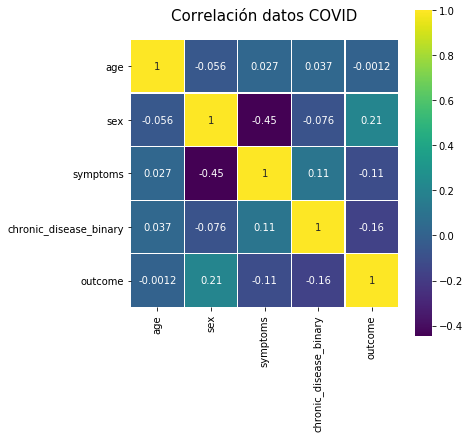

In [23]:
# Se realiza una gráfica para ver cuáles tienen mayor relación dentro del dataset
colormap = plt.cm.viridis
plt.figure(figsize=(6,6))
plt.title('Correlación datos COVID', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Calculando el gini

In [24]:
train[['sex', 'outcome']].groupby(['sex'], as_index=False).agg(['mean', 'count', 'sum'])

outcome              
         mean  count    sum
sex                        
0    0.931777    557    519
1    0.936351    707    662
2    0.998678  12862  12845

In [25]:
train[['symptoms', 'outcome']].groupby(['symptoms'], as_index=False).agg(['mean', 'count', 'sum'])

outcome              
              mean  count    sum
symptoms                        
0         0.994673  13703  13630
1         0.944444    234    221
2         0.913043     46     42
3         0.930769    130    121
4         0.923077     13     12

In [26]:
# Se calcula el gini de sexo y síntomas
def get_gini_impurity(alive_count, total_count):
    alive_prob = alive_count/total_count
    death_prob = (1 - alive_prob)
    random_observation_alive_prob = alive_prob
    random_observation_death_prob = (1 - random_observation_alive_prob)
    mislabelling_alive_prob = death_prob * random_observation_alive_prob
    mislabelling_death_prob = alive_prob * random_observation_death_prob
    gini_impurity = mislabelling_alive_prob + mislabelling_death_prob
    return gini_impurity

In [27]:
# Gini Impurity of starting node
gini_impurity_starting_node = get_gini_impurity(14026, 14126)
gini_impurity_starting_node

0.0140580610952951

In [28]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(662, 707)
gini_impurity_men

0.11919599719115169

In [29]:
# Gini Impurity decrease of node for 'female' observations
gini_impurity_women = get_gini_impurity(519, 557)
gini_impurity_women

0.12713659028715638

In [30]:
# Gini Impurity decrease of node for 'Non-specifies' observations
gini_impurity_non = get_gini_impurity(12845, 12862)
gini_impurity_non

0.0026399519064874196

In [31]:
# Valor del gini para sexo
men_weight = 662/707
women_weight = 519/557
non_weight = 12845/12862
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight) + (gini_impurity_non * non_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

0.2186506650722091

In [32]:
# Gini Impurity decrease of node for 'others' observations
gini_impurity_others = get_gini_impurity(13630, 13703)
gini_impurity_others

0.010597840919046721

In [33]:
# Gini Impurity decrease of node for 'fever' observations
gini_impurity_fever = get_gini_impurity(221, 234)
gini_impurity_fever

0.10493827160493832

In [34]:
# Gini Impurity decrease of node for 'cough' observations
gini_impurity_cough = get_gini_impurity(121, 130)
gini_impurity_cough

0.12887573964497037

In [35]:
# Gini Impurity decrease of node for 'fever and cough' observations
gini_impurity_fever_and_cough = get_gini_impurity(121, 130)
gini_impurity_fever_and_cough

0.12887573964497037

In [36]:
# Gini Impurity decrease of node for 'asymptomatic' observations
gini_impurity_asymptomatic = get_gini_impurity(12, 13)
gini_impurity_asymptomatic

0.14201183431952655

In [37]:
# Valor del gini para síntomas
others_weight = 13630/13730
fever_weight = 221/234
cough_weight = 42/46
fever_and_cough_weight = 121/130
asymptomatic_weight = 12/13
weighted_gini_impurity_symptoms_split = (gini_impurity_others * others_weight) + (gini_impurity_fever * fever_weight) + (gini_impurity_cough * cough_weight) + (gini_impurity_fever_and_cough * fever_and_cough_weight) + (gini_impurity_asymptomatic * asymptomatic_weight)

symptoms_gini_decrease = weighted_gini_impurity_symptoms_split - gini_impurity_starting_node
symptoms_gini_decrease

0.46428153367848557

# Cross Validation
Se realiza este método para obtener el número de max depth que será utilizado en el árbol de decisión.

In [38]:
cv = KFold(n_splits=10) 
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold] # Extract train data with cv indices
        f_valid = train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['outcome'], axis=1), 
                               y = f_train["outcome"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['outcome'], axis=1), 
                                y = f_valid["outcome"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.992921
         2          0.992567
         3          0.992992
         4          0.993346
         5          0.993275


# Árbol de decisión con sklearn

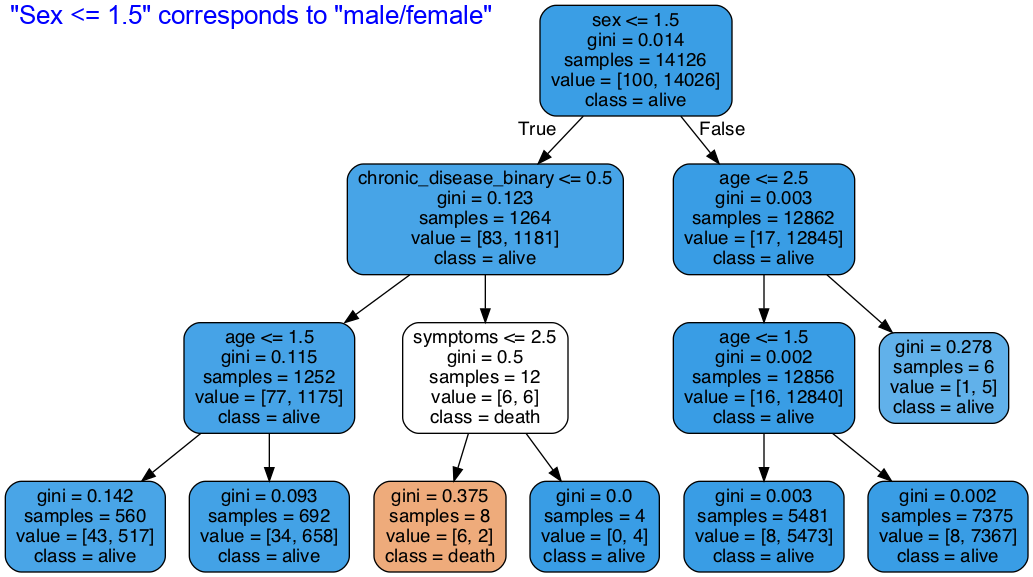

In [52]:
import graphviz
#Usar el 3
y_train = train['outcome']
x_train = train.drop(['outcome'], axis=1).values 
x_test = test.drop(['outcome'], axis=1).values

# Create Decision Tree with max_depth = 3
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        'ID': id,
        "outcome": y_pred
    })
submission.to_csv('submission.csv', index=False)

with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train.drop(['outcome'], axis=1)),
                              class_names = ['death', 'alive'],
                              rounded = True,
                              filled= True )


check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('Arial', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Sex <= 1.5" corresponds to "male/female"', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

In [49]:
# Se obtiene la exactitud del modelo obtenido
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

99.32